# Healthcare Vulnerability Analysis in Catalonia

This notebook presents a detailed analysis of the distribution of healthcare resources (hospitals and defibrillators) in relation to the socioeconomic level of the comarcas (counties) of Catalonia.

The objective is to identify critical zones where high social vulnerability coincides with low healthcare resource coverage.

### 1. Loading libraries and data acquisition
We connect to the Transparency API of Catalonia to obtain real-time data on defibrillators and hospitals, and we load local socioeconomic data.

In [ ]:
import pandas as pd
from sodapy import Socrata
import seaborn as sns

# Connection to the Transparency Catalonia API
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Downloading datasets: Defibrillators (AED) and Hospitals
desfibriladors = client.get("wpud-ukyg")
hospitales = client.get("8gmd-gz7i")

# Loading local socioeconomic data
df_socioeconomic = pd.read_csv("socio_eco.csv")

### 2. Processing of socioeconomic indicators
We clean the census data and build a custom **Socioeconomic Poverty Index**. This index combines key variables such as education level, per capita income, and unemployment rate to score the vulnerability of each municipality.

In [ ]:
# Cleaning the census dataset
df_cens = pd.read_csv("cens.csv", sep=';')
df_cens.drop(columns=['estat', 'any', 'concepte', 'geo'], inplace=True)

# Filtering irrelevant rows (totals or groupings)
df_cens = df_cens[~df_cens['edat'].str.contains('any', na=False)]
df_cens = df_cens[~df_cens['sexe'].str.contains('homes', na=False)]
df_cens = df_cens[~df_cens['sexe'].str.contains('dones', na=False)]
df_cens = df_cens[~df_cens['municipi'].str.contains('anys', na=False)]
df_cens.drop(columns=['edat', 'sexe'], inplace=True)

# Processing socioeconomic data
df_socioeconomic = pd.read_csv("socio_eco.csv")
df_socioeconomic = df_socioeconomic[['any', 'municipi', 'concepte', 'valor']]
df_socioeconomic['valor'] = pd.to_numeric(df_socioeconomic['valor'], errors='coerce')

# Pivot table to have concepts as columns
df_socioeconomic = df_socioeconomic.pivot_table(
    index=['any', 'municipi'],
    columns='concepte',
    values='valor',
    aggfunc='first'
).reset_index()

# Imputation of null values with the mean
for column in df_socioeconomic.columns:
    if df_socioeconomic[column].dtype in ['float64', 'int64']:
        mean_value = df_socioeconomic[column].mean()
        df_socioeconomic[column].fillna(mean_value, inplace=True)

# Create unemployment variable
df_socioeconomic['població desocupada(%)'] = 100 - df_socioeconomic['població ocupada (%)']
df_socioeconomic.drop(columns=['població ocupada (%)'], inplace=True)

# Min-Max Normalization of numeric columns
numeric_columns = df_socioeconomic.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    min_value = df_socioeconomic[column].min()
    max_value = df_socioeconomic[column].max()
    df_socioeconomic[column] = (df_socioeconomic[column] - min_value) / (max_value - min_value)

df_socioeconomic.drop(columns=['any', 'estrangers de països de renda baixa o mitjana (%)'], inplace=True)

# Calculation of the Socioeconomic Poverty Index (Manual weighting)
# Higher value = Higher vulnerability
df_socioeconomic['puntuació pobreza socioeconòmica'] = (
    df_socioeconomic['població amb estudis baixos (%)'] * (1/3) +
    df_socioeconomic['població jove sense estudis postobligatoris (%)'] * (1/6) -
    df_socioeconomic['renda mitjana per persona (€)'] * (1/3) +
    df_socioeconomic['treballadors de baixa qualificació (%)'] * (1/12) +
    df_socioeconomic['població desocupada(%)'] * (1/12)
)

C:\Users\German\AppData\Local\Temp\ipykernel_22100\3423289792.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens = pd.read_csv("cens.csv", sep=';')
C:\Users\German\AppData\Local\Temp\ipykernel_22100\3423289792.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_socioeconomic[column].fillna(mean_value, inplace=True)


### 3. Index validation using PCA
To ensure the robustness of our manual index, we perform a **Principal Component Analysis (PCA)**. We compare our calculated index with the first principal component (PC1) to verify if we correctly capture the variance of the data.

Pesos del PCA:
població amb estudis baixos (%)                    0.476087
població jove sense estudis postobligatoris (%)    0.526400
treballadors de baixa qualificació (%)             0.306693
població desocupada(%)                             0.365872
renta_inv                                          0.517998
dtype: float64

Varianza explicada por la primera componente: 0.547710004148582


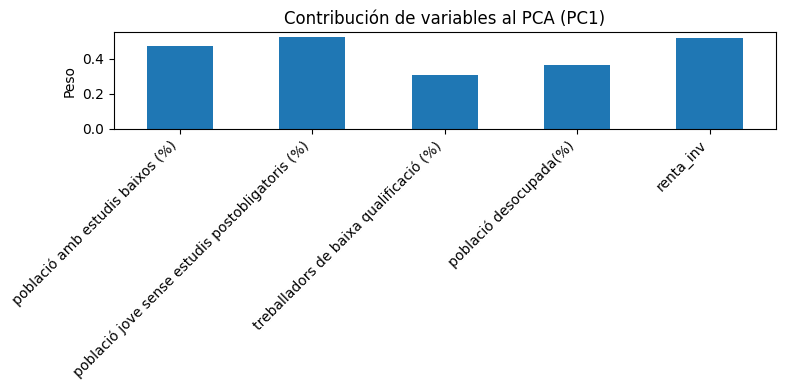

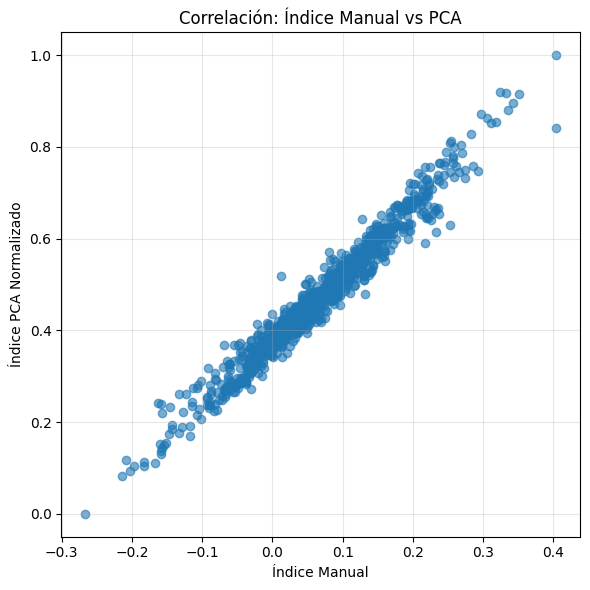

Correlación manual vs PCA = 0.9803282244785025


In [ ]:
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Selected variables for the index
vars_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renda mitjana per persona (€)'
]

# We invert income so that the direction is consistent (Higher value = Higher poverty)
df_socioeconomic['renta_inv'] = 1 - df_socioeconomic['renda mitjana per persona (€)']

vars_for_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renta_inv'
]

X = df_socioeconomic[vars_for_pca].values

# Apply PCA (1 component)
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X)

df_socioeconomic['indice_pca_bruto'] = pc1[:, 0]

# Normalize PCA index to [0,1]
idx = df_socioeconomic['indice_pca_bruto']
df_socioeconomic['indice_pca_norm'] = (idx - idx.min()) / (idx.max() - idx.min())

# PCA Results
pesos_pca = pd.Series(pca.components_[0], index=vars_for_pca)
print("PCA Weights:")
print(pesos_pca)
print("\nVariance explained by the first component:", pca.explained_variance_ratio_[0])

# Visualization of weights
plt.figure(figsize=(8,4))
pesos_pca.plot(kind='bar')
plt.title("Contribution of variables to PCA (PC1)")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Comparison: Manual Index vs PCA
plt.figure(figsize=(6,6))
plt.scatter(
    df_socioeconomic['puntuació pobreza socioeconòmica'], 
    df_socioeconomic['indice_pca_norm'],
    alpha=0.6
)
plt.xlabel("Manual Index")
plt.ylabel("Normalized PCA Index")
plt.title("Correlation: Manual Index vs PCA")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

corr = df_socioeconomic['puntuació pobreza socioeconòmica'].corr(df_socioeconomic['indice_pca_norm'])
print("Manual vs PCA Correlation =", corr)

### 4. Aggregation of healthcare resources
We process the raw data from the API to count how many **defibrillators** and **hospitals** exist in each municipality and comarca. This will allow us to calculate the density of resources.

In [ ]:
df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitales = pd.DataFrame.from_records(hospitales) 

# Selection of relevant columns
df_desfibriladors = df_desfibriladors[['comarca', 'municipi']]
df_hospitales = df_hospitales[['poblacio', 'comarca']]

# Count of resources by municipality and comarca
des_count_municipi = df_desfibriladors['municipi'].value_counts().reset_index()
des_count_comarca = df_desfibriladors['comarca'].value_counts().reset_index() 

hospi_count_municipi = df_hospitales['poblacio'].value_counts().reset_index()
hospi_count_comarca = df_hospitales['comarca'].value_counts().reset_index()

# Unification of data by municipality
recursos_municipi = pd.merge(des_count_municipi, hospi_count_municipi, left_on='municipi', right_on='poblacio', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
recursos_municipi['recursos_sanitaris_totals'] = recursos_municipi['count_desfibriladors'] + recursos_municipi['count_hospitals']

# Unification of data by comarca
recursos_comarca = pd.merge(des_count_comarca, hospi_count_comarca, left_on='comarca', right_on='comarca', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
recursos_comarca['recursos_sanitaris_totals'] = recursos_comarca['count_desfibriladors'] + recursos_comarca['count_hospitals']

### 5. Healthcare resource density map
We cross the resource data with the population of each comarca to obtain the ratio of **Resources per 1000 inhabitants**. We visualize this distribution on a map, applying outlier filtering to improve visualization.

Límite superior (p96) para visualización: 1.37


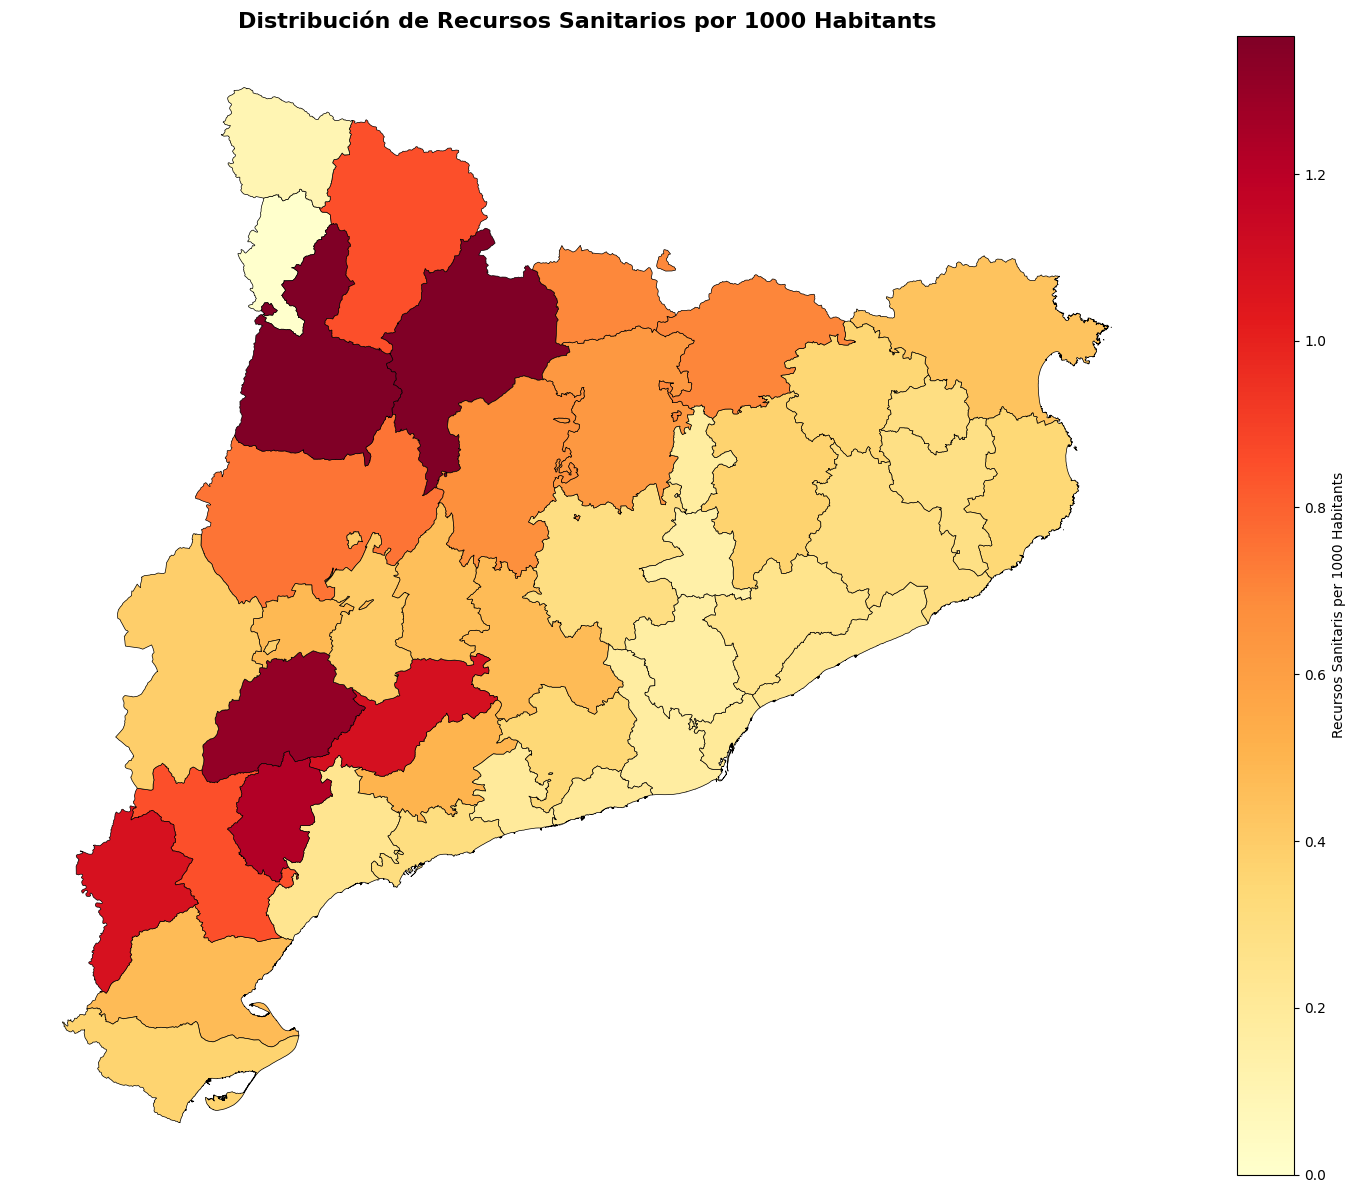

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "carto/"

municipis_geo = gpd.read_file(data_dir + "muni.json")
comarcas = gpd.read_file(data_dir + "comarcas.json")

# Assign comarca to each census municipality
df_cens_comarca = df_cens.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                 left_on='municipi', 
                                 right_on='NOMMUNI', 
                                 how='left')

# Calculate total population by comarca
poblacio_per_comarca = df_cens_comarca.groupby('NOMCOMAR')['valor'].sum().reset_index()
poblacio_per_comarca.columns = ['comarca', 'poblacio']

# Calculate resource ratio
recursos_comarca_poblacio = recursos_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
recursos_comarca_poblacio['recursos_per_1000_hab'] = (recursos_comarca_poblacio['recursos_sanitaris_totals'] / recursos_comarca_poblacio['poblacio']) * 1000

# Outlier treatment (Capped at 96th percentile)
percentil_96 = recursos_comarca_poblacio['recursos_per_1000_hab'].quantile(0.96)
print(f"Upper limit (p96) for visualization: {percentil_96:.2f}")

recursos_comarca_poblacio['recursos_per_1000_hab'] = recursos_comarca_poblacio['recursos_per_1000_hab'].clip(upper=percentil_96)

# GeoDataFrame preparation
comarcas_recursos = comarcas.merge(recursos_comarca_poblacio, left_on='NOMCOMAR', right_on='comarca', how='left')
comarcas_recursos['recursos_per_1000_hab'] = comarcas_recursos['recursos_per_1000_hab'].fillna(0)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
comarcas_recursos.plot(column='recursos_per_1000_hab', 
                        ax=ax, 
                        legend=True,
                        cmap='YlOrRd',
                        edgecolor='black',
                        linewidth=0.5,
                        legend_kwds={'label': "Healthcare Resources per 1000 Inhabitants",
                                     'orientation': "vertical"})

ax.set_title('Distribution of Healthcare Resources per 1000 Inhabitants', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### 6. Socioeconomic vulnerability map
We visualize the **Socioeconomic Poverty Index** aggregated by comarca. Red zones indicate higher vulnerability (worse socioeconomic indicators), while green zones indicate higher well-being.

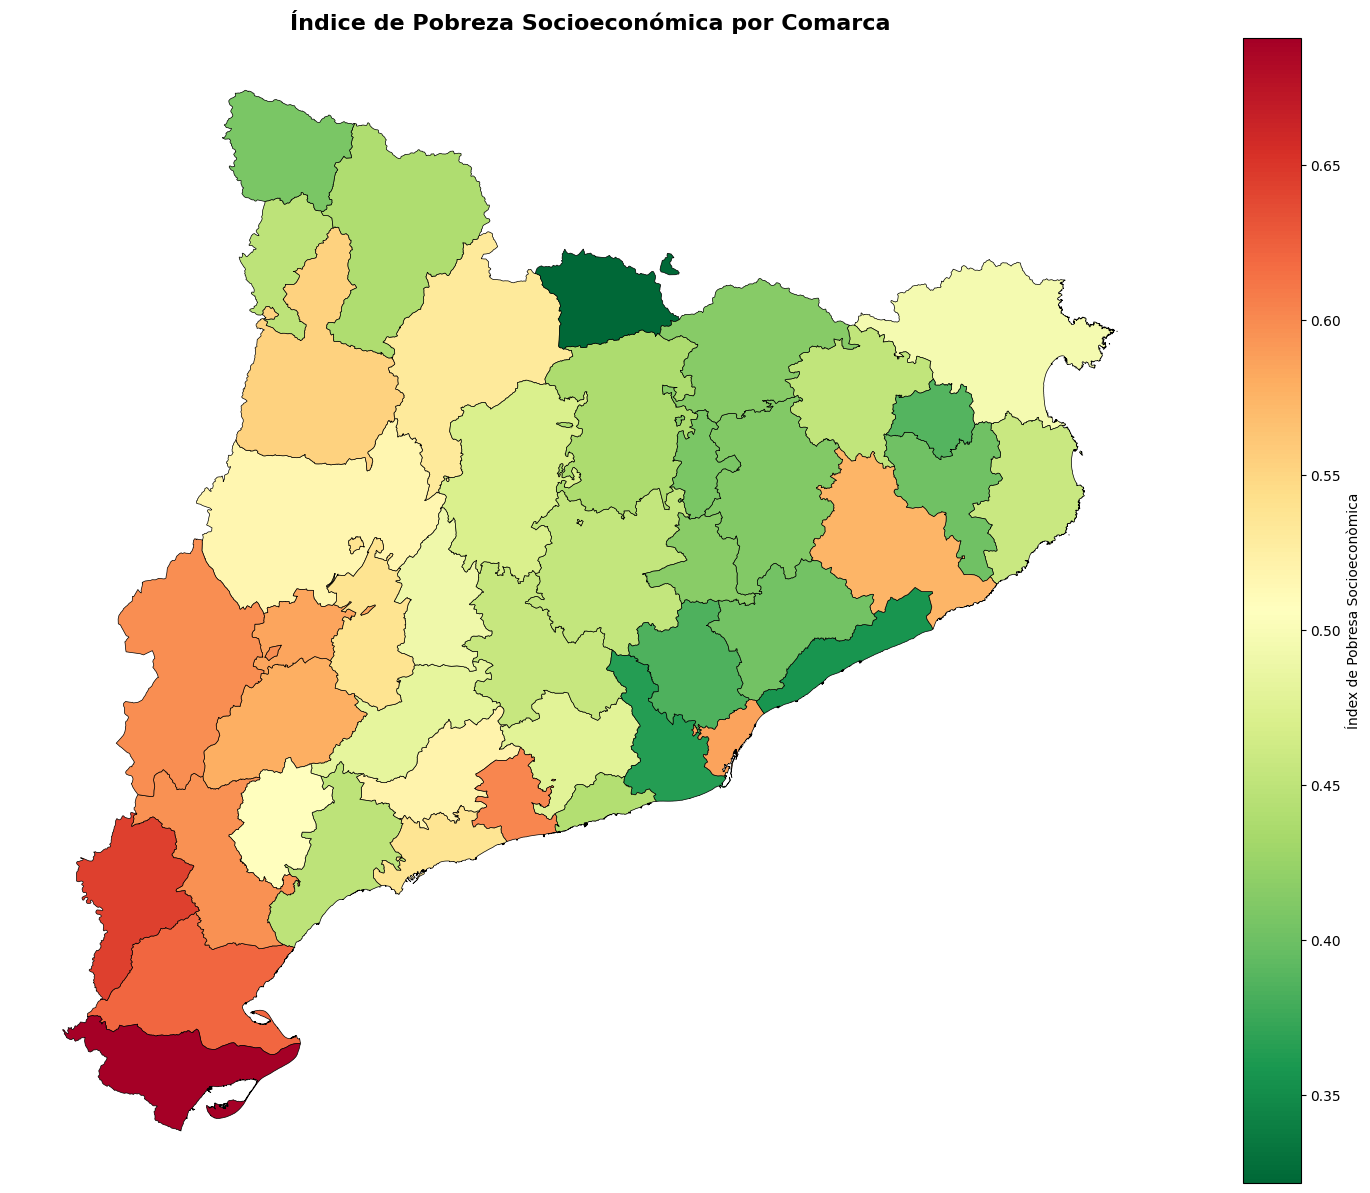

In [ ]:
# Assign comarca to socioeconomic data
df_socioeconomic_comarca = df_socioeconomic.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                                    left_on='municipi', 
                                                    right_on='NOMMUNI', 
                                                    how='left')

# Average poverty index by comarca
pobreza_per_comarca = df_socioeconomic_comarca.groupby('NOMCOMAR')['indice_pca_norm'].mean().reset_index()
pobreza_per_comarca.columns = ['comarca', 'puntuacio_pobreza']

# GeoDataFrame preparation
comarcas_pobreza = comarcas.merge(pobreza_per_comarca, left_on='NOMCOMAR', right_on='comarca', how='left')
comarcas_pobreza['puntuacio_pobreza'] = comarcas_pobreza['puntuacio_pobreza'].fillna(0)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
comarcas_pobreza.plot(column='puntuacio_pobreza', 
                       ax=ax, 
                       legend=True,
                       cmap='RdYlGn_r',  # Red = more poverty
                       edgecolor='black',
                       linewidth=0.5,
                       legend_kwds={'label': "Socioeconomic Poverty Index",
                                    'orientation': "vertical"})

ax.set_title('Socioeconomic Poverty Index by Comarca', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### 7. Bivariate Analysis: Total Resources vs. Poverty
We cross both dimensions to identify patterns. We use a **bivariate map** and a **clustering analysis (K-Means)** to classify the comarcas into three groups:
1. **Critical:** High poverty and low resources (High priority).
2. **High resources:** High poverty but compensated with resources.
3. **Low risk:** Low poverty.

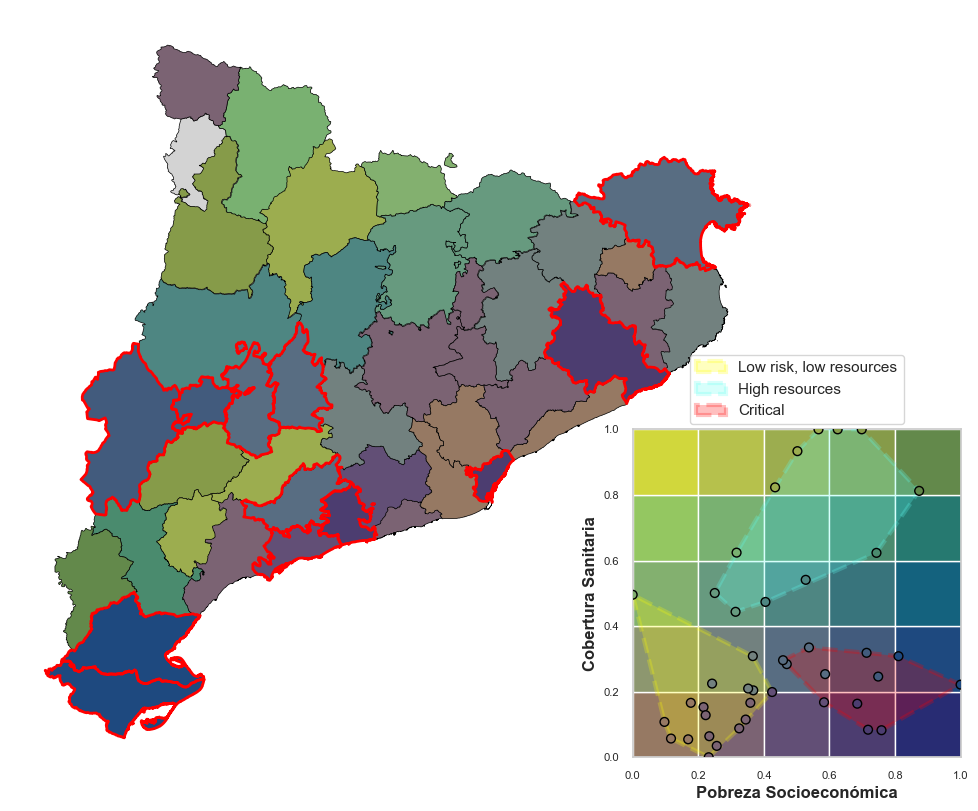

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# --- Data Preparation ---
datos_combinados = recursos_comarca_poblacio.merge(pobreza_per_comarca, on='comarca', how='inner')

# Outlier filtering for clustering (avoid distortion)
percentil_95 = datos_combinados['recursos_per_1000_hab'].quantile(0.95)
mask_no_outliers = datos_combinados['recursos_per_1000_hab'] <= percentil_95
datos_combinados['recursos_per_1000_hab'] = datos_combinados['recursos_per_1000_hab'].clip(upper=percentil_95)

# Normalization [0, 1]
min_recursos = datos_combinados['recursos_per_1000_hab'].min()
max_recursos = datos_combinados['recursos_per_1000_hab'].max()
datos_combinados['recursos_norm'] = (datos_combinados['recursos_per_1000_hab'] - min_recursos) / (max_recursos - min_recursos)

min_pobreza = datos_combinados['puntuacio_pobreza'].min()
max_pobreza = datos_combinados['puntuacio_pobreza'].max()
datos_combinados['pobreza_norm'] = (datos_combinados['puntuacio_pobreza'] - min_pobreza) / (max_pobreza - min_pobreza)

# --- Clustering (K-Means) ---
X = datos_combinados[['pobreza_norm', 'recursos_norm']].values
X_fit = X[mask_no_outliers] 

kmeans = KMeans(n_clusters=3, random_state=42, n_init=5)
kmeans.fit(X_fit)
datos_combinados['Cluster'] = kmeans.predict(X)

# Automatic cluster labeling
centroids = datos_combinados.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices = centroids.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels = {}
cluster_labels[sorted_indices[2]] = "Low risk, low resources" # Lower poverty

# Differentiate the two higher poverty groups by their resources
idx_a, idx_b = sorted_indices[0], sorted_indices[1]
if centroids.loc[idx_a, 'recursos_norm'] < centroids.loc[idx_b, 'recursos_norm']:
    cluster_labels[idx_a] = "Critical"
    cluster_labels[idx_b] = "High resources"
else:
    cluster_labels[idx_a] = "High resources"
    cluster_labels[idx_b] = "Critical"

datos_combinados['label'] = datos_combinados['Cluster'].map(cluster_labels)

# --- Bivariate Color Configuration ---
n_bins = 5
datos_combinados['pobreza_bin'] = np.floor(datos_combinados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_combinados['recursos_bin'] = np.floor(datos_combinados['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

colors_pobreza = plt.cm.cividis_r(np.linspace(0, 1, 256))
cmap_pobreza = LinearSegmentedColormap.from_list('pobreza', colors_pobreza)
colors_recursos = plt.cm.viridis(np.linspace(0, 1, 256))
cmap_recursos = LinearSegmentedColormap.from_list('recursos', colors_recursos)

def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    return [(col_pob[0] + col_rec[0])/2, (col_pob[1] + col_rec[1])/2, (col_pob[2] + col_rec[2])/2]

datos_combinados['color_rgb'] = datos_combinados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_combinado = comarcas.merge(datos_combinados, left_on='NOMCOMAR', right_on='comarca', how='left')

# --- Visualization ---
fig, ax_map = plt.subplots(1, 1, figsize=(10, 10))

# Main map
comarcas_con_color = comarcas_combinado[comarcas_combinado['color_rgb'].notna()].copy()
comarcas_sin_color = comarcas_combinado[comarcas_combinado['color_rgb'].isna()]

if len(comarcas_sin_color) > 0:
    comarcas_sin_color.plot(ax=ax_map, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color.iterrows():
    comarcas_con_color.loc[[idx]].plot(ax=ax_map, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# Highlight critical zones
comarcas_criticas = comarcas_combinado[comarcas_combinado['label'] == 'Critical']
if not comarcas_criticas.empty:
    comarcas_criticas.plot(ax=ax_map, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map.axis('off')

# Bivariate Legend (Scatter Inset)
ax_scatter = ax_map.inset_axes([0.80, 0.02, 0.43, 0.43])

# Color grid background
for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter.add_patch(rect)

# Convex Hulls for clusters
cluster_colors = {'Critical': '#FF0000', 'High resources': "#60FFF2", 'Low risk, low resources': '#FFFF00'}
unique_clusters = np.sort(datos_combinados['Cluster'].unique())

for cluster in unique_clusters:
    cluster_data = datos_combinados[datos_combinados['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter.add_patch(poly)

# Comarca points
ax_scatter.scatter(
    datos_combinados['pobreza_norm'],
    datos_combinados['recursos_norm'],
    c=datos_combinados['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter.set_xlim(0, 1)
ax_scatter.set_ylim(0, 1)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlabel('Socioeconomic Poverty', fontsize=12, fontweight='bold')
ax_scatter.set_ylabel('Healthcare Coverage', fontsize=12, fontweight='bold')
ax_scatter.tick_params(labelsize=8)
ax_scatter.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=11, ncol=1)

plt.show()

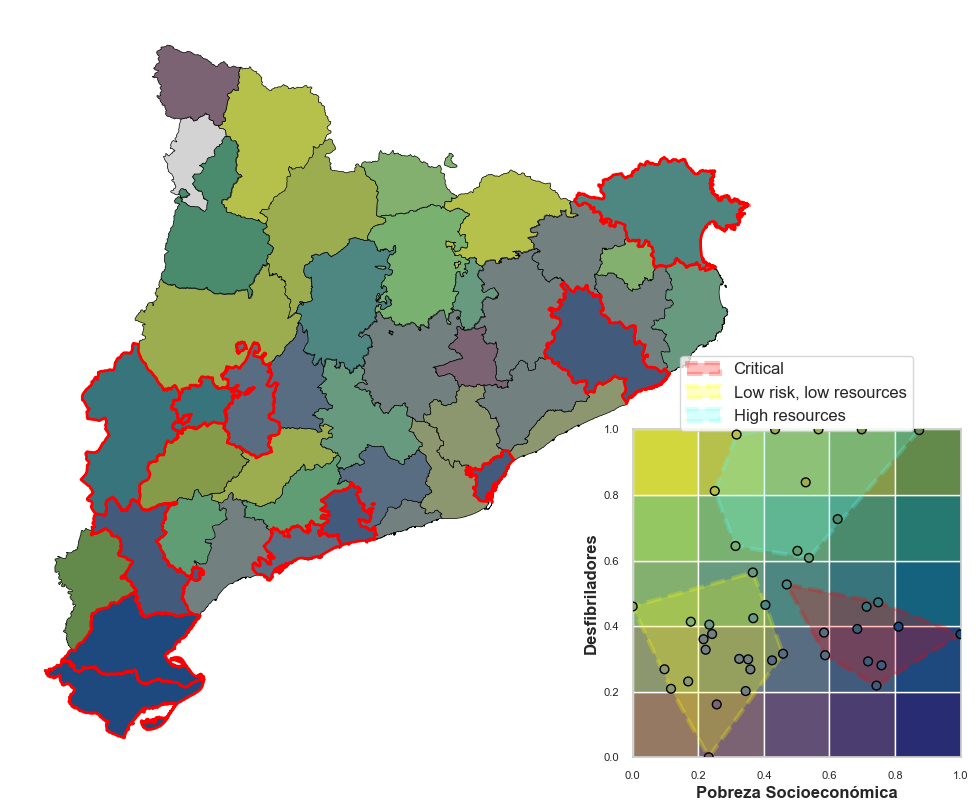

In [ ]:
# --- Data Preparation (Defibrillators) ---
desfib_per_comarca = recursos_comarca[['comarca', 'count_desfibriladors']].copy()
desfib_per_comarca = desfib_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
desfib_per_comarca['desfib_per_1000_hab'] = (desfib_per_comarca['count_desfibriladors'] / desfib_per_comarca['poblacio']) * 1000

datos_desfib = desfib_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# Clip and Normalization
percentil_95_d = datos_desfib['desfib_per_1000_hab'].quantile(0.95)
datos_desfib['desfib_per_1000_hab'] = datos_desfib['desfib_per_1000_hab'].clip(upper=percentil_95_d)

min_recursos_d = datos_desfib['desfib_per_1000_hab'].min()
max_recursos_d = datos_desfib['desfib_per_1000_hab'].max()
datos_desfib['recursos_norm'] = (datos_desfib['desfib_per_1000_hab'] - min_recursos_d) / (max_recursos_d - min_recursos_d)

min_pobreza_d = datos_desfib['puntuacio_pobreza'].min()
max_pobreza_d = datos_desfib['puntuacio_pobreza'].max()
datos_desfib['pobreza_norm'] = (datos_desfib['puntuacio_pobreza'] - min_pobreza_d) / (max_pobreza_d - min_pobreza_d)

# --- Clustering ---
X_d = datos_desfib[['pobreza_norm', 'recursos_norm']].values
kmeans_d = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_d.fit(X_d)
datos_desfib['Cluster'] = kmeans_d.predict(X_d)

# Labels
centroids_d = datos_desfib.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices_d = centroids_d.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels_d = {}
cluster_labels_d[sorted_indices_d[2]] = "Low risk, low resources"

idx_a, idx_b = sorted_indices_d[0], sorted_indices_d[1]
if centroids_d.loc[idx_a, 'recursos_norm'] < centroids_d.loc[idx_b, 'recursos_norm']:
    cluster_labels_d[idx_a] = "Critical"
    cluster_labels_d[idx_b] = "High resources"
else:
    cluster_labels_d[idx_a] = "High resources"
    cluster_labels_d[idx_b] = "Critical"

datos_desfib['label'] = datos_desfib['Cluster'].map(cluster_labels_d)

# --- Visualization ---
n_bins = 5
datos_desfib['pobreza_bin'] = np.floor(datos_desfib['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_desfib['recursos_bin'] = np.floor(datos_desfib['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

datos_desfib['color_rgb'] = datos_desfib.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_desfib = comarcas.merge(datos_desfib, left_on='NOMCOMAR', right_on='comarca', how='left')

fig, ax_map_d = plt.subplots(1, 1, figsize=(10, 10))

# Map
comarcas_con_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].notna()].copy()
comarcas_sin_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].isna()]

if len(comarcas_sin_color_d) > 0:
    comarcas_sin_color_d.plot(ax=ax_map_d, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_d.iterrows():
    comarcas_con_color_d.loc[[idx]].plot(ax=ax_map_d, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# Highlight critical
comarcas_criticas_d = comarcas_desfib[comarcas_desfib['label'] == 'Critical']
if not comarcas_criticas_d.empty:
    comarcas_criticas_d.plot(ax=ax_map_d, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map_d.axis('off')

# Inset Scatter
ax_scatter_d = ax_map_d.inset_axes([0.80, 0.02, 0.43, 0.43])

for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter_d.add_patch(rect)

unique_clusters_d = np.sort(datos_desfib['Cluster'].unique())

for cluster in unique_clusters_d:
    cluster_data = datos_desfib[datos_desfib['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels_d[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter_d.add_patch(poly)

ax_scatter_d.scatter(
    datos_desfib['pobreza_norm'],
    datos_desfib['recursos_norm'],
    c=datos_desfib['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter_d.set_xlim(0, 1)
ax_scatter_d.set_ylim(0, 1)
ax_scatter_d.set_aspect('equal')
ax_scatter_d.set_xlabel('Socioeconomic Poverty', fontsize=12, fontweight='bold')
ax_scatter_d.set_ylabel('Defibrillators', fontsize=12, fontweight='bold')
ax_scatter_d.tick_params(labelsize=8)
ax_scatter_d.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=12, ncol=1)

plt.show()

### 8. Bivariate Analysis: Defibrillators vs. Poverty
We repeat the analysis focusing exclusively on the availability of **Defibrillators (AED)**. This allows us to see if the distribution of these emergency devices follows different patterns than general resources.

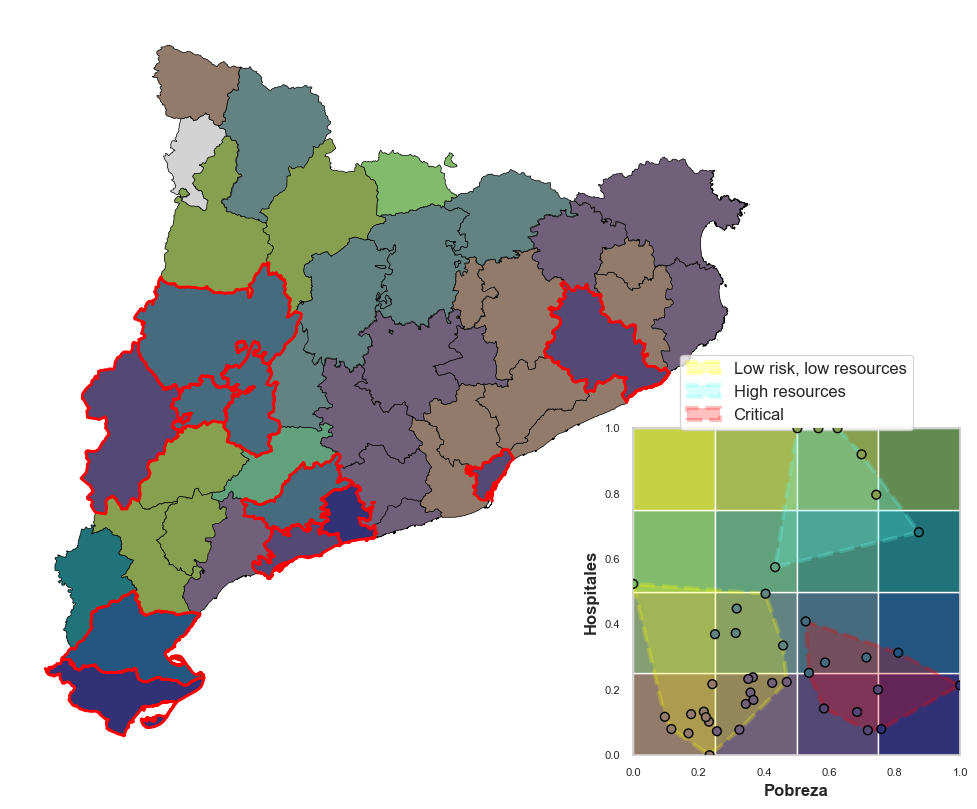

In [ ]:
# --- Data Preparation (Hospitals) ---
hospi_per_comarca = recursos_comarca[['comarca', 'count_hospitals']].copy()
hospi_per_comarca = hospi_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
hospi_per_comarca['hospi_per_1000_hab'] = (hospi_per_comarca['count_hospitals'] / hospi_per_comarca['poblacio']) * 1000

datos_hospi = hospi_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# Clip and Normalization
percentil_95_h = datos_hospi['hospi_per_1000_hab'].quantile(0.95)
datos_hospi['hospi_per_1000_hab'] = datos_hospi['hospi_per_1000_hab'].clip(upper=percentil_95_h)

min_recursos_h = datos_hospi['hospi_per_1000_hab'].min()
max_recursos_h = datos_hospi['hospi_per_1000_hab'].max()
datos_hospi['recursos_norm'] = (datos_hospi['hospi_per_1000_hab'] - min_recursos_h) / (max_recursos_h - min_recursos_h)

min_pobreza_h = datos_hospi['puntuacio_pobreza'].min()
max_pobreza_h = datos_hospi['puntuacio_pobreza'].max()
datos_hospi['pobreza_norm'] = (datos_hospi['puntuacio_pobreza'] - min_pobreza_h) / (max_pobreza_h - min_pobreza_h)

# --- Clustering ---
X_h = datos_hospi[['pobreza_norm', 'recursos_norm']].values
kmeans_h = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_h.fit(X_h)
datos_hospi['Cluster'] = kmeans_h.predict(X_h)

# Labels
centroids_h = datos_hospi.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices_h = centroids_h.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels_h = {}
cluster_labels_h[sorted_indices_h[2]] = "Low risk, low resources"

idx_a, idx_b = sorted_indices_h[0], sorted_indices_h[1]
if centroids_h.loc[idx_a, 'recursos_norm'] < centroids_h.loc[idx_b, 'recursos_norm']:
    cluster_labels_h[idx_a] = "Critical"
    cluster_labels_h[idx_b] = "High resources"
else:
    cluster_labels_h[idx_a] = "High resources"
    cluster_labels_h[idx_b] = "Critical"

datos_hospi['label'] = datos_hospi['Cluster'].map(cluster_labels_h)

# --- Visualization ---
n_bins = 4
datos_hospi['pobreza_bin'] = np.floor(datos_hospi['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_hospi['recursos_bin'] = np.floor(datos_hospi['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

datos_hospi['color_rgb'] = datos_hospi.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_hospi = comarcas.merge(datos_hospi, left_on='NOMCOMAR', right_on='comarca', how='left')

fig, ax_map_h = plt.subplots(1, 1, figsize=(10, 10))

# Map
comarcas_con_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].notna()].copy()
comarcas_sin_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].isna()]

if len(comarcas_sin_color_h) > 0:
    comarcas_sin_color_h.plot(ax=ax_map_h, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_h.iterrows():
    comarcas_con_color_h.loc[[idx]].plot(ax=ax_map_h, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# Highlight critical
comarcas_criticas_h = comarcas_hospi[comarcas_hospi['label'] == 'Critical']
if not comarcas_criticas_h.empty:
    comarcas_criticas_h.plot(ax=ax_map_h, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map_h.axis('off')

# Inset Scatter
ax_scatter_h = ax_map_h.inset_axes([0.80, 0.02, 0.43, 0.43])

for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter_h.add_patch(rect)

unique_clusters_h = np.sort(datos_hospi['Cluster'].unique())

for cluster in unique_clusters_h:
    cluster_data = datos_hospi[datos_hospi['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels_h[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter_h.add_patch(poly)

ax_scatter_h.scatter(
    datos_hospi['pobreza_norm'],
    datos_hospi['recursos_norm'],
    c=datos_hospi['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter_h.set_xlim(0, 1)
ax_scatter_h.set_ylim(0, 1)
ax_scatter_h.set_aspect('equal')
ax_scatter_h.set_xlabel('Poverty', fontsize=12, fontweight='bold')
ax_scatter_h.set_ylabel('Hospitals', fontsize=12, fontweight='bold')
ax_scatter_h.tick_params(labelsize=8)
ax_scatter_h.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=12, ncol=1)

plt.show()

### 9. Bivariate Analysis: Hospitals vs. Poverty
Finally, we analyze the distribution of **Hospitals**. Since they are critical infrastructures and less numerous, their distribution can vary significantly compared to AEDs.

✅ Analizando datos generales (Recursos Totales)

 TOP 10 COMARCAS CON MAYOR VULNERABILIDAD SANITARIA
     comarca  Indice_Prioridad  recursos_per_1000_hab  puntuacio_pobreza
     Montsià          1.778540               0.364941           0.690868
Baix Penedès          1.676396               0.197029           0.601858
  Barcelonès          1.633884               0.198842           0.586720
       Selva          1.521623               0.294678           0.574568
      Segrià          1.502753               0.394633           0.598145
   Baix Ebre          1.502488               0.469682           0.620980
  Tarragonès          1.415944               0.299951           0.537172
Pla d'Urgell          1.394833               0.482146           0.585052
      Urgell          1.333435               0.403649           0.538404
      Garraf          1.236827               0.203821           0.441685


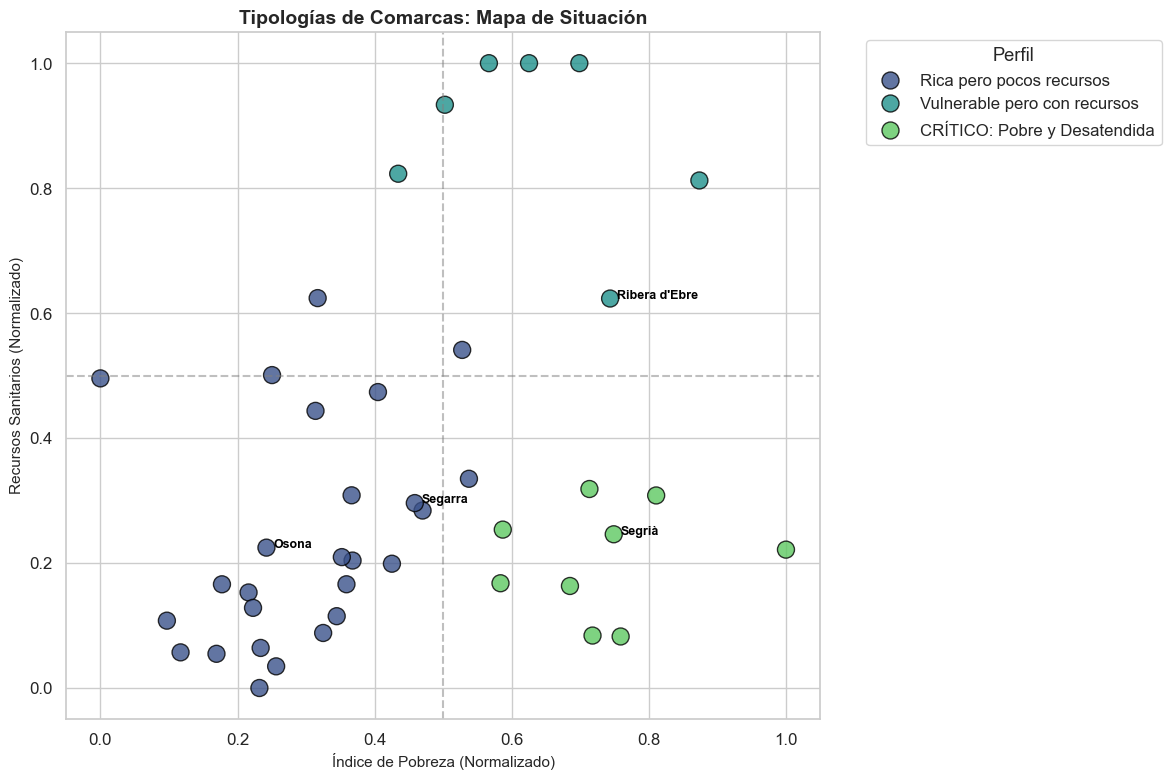


Resumen de tipologías:
Etiqueta_Cluster
Rica pero pocos recursos        26
CRÍTICO: Pobre y Desatendida     9
Vulnerable pero con recursos     7
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# --- Automatic detection of the DataFrame to analyze ---
if 'datos_combinados' in locals():
    df_analisis = datos_combinados.copy()
    print("✅ Analyzing general data (Total Resources)")
elif 'datos_combinados_filtrados' in locals():
    df_analisis = datos_combinados_filtrados.copy()
    print("✅ Analyzing filtered data")
else:
    raise ValueError("❌ No processed data found. Run the previous cells.")

# Ensure normalized columns
if 'pobreza_norm' not in df_analisis.columns:
    col_origen = 'puntuacio_pobreza' if 'puntuacio_pobreza' in df_analisis.columns else 'indice_pca_norm'
    df_analisis['pobreza_norm'] = (df_analisis[col_origen] - df_analisis[col_origen].min()) / \
                                  (df_analisis[col_origen].max() - df_analisis[col_origen].min())

posibles_recursos = ['recursos_sin_norm', 'recursos_per_1000_hab', 'desfib_per_1000_hab']
col_recursos_orig = next((c for c in posibles_recursos if c in df_analisis.columns), None)

if col_recursos_orig:
    df_analisis['recursos_norm'] = (df_analisis[col_recursos_orig] - df_analisis[col_recursos_orig].min()) / \
                                   (df_analisis[col_recursos_orig].max() - df_analisis[col_recursos_orig].min())

# --- 1. Priority Ranking ---
# Formula: Higher Poverty + Lower Resources = Higher Priority
df_analisis['Indice_Prioridad'] = df_analisis['pobreza_norm'] + (1 - df_analisis['recursos_norm'])

print(f"\n{'='*60}\n TOP 10 COMARCAS WITH HIGHEST HEALTHCARE VULNERABILITY\n{'='*60}")
top_prioridad = df_analisis.sort_values('Indice_Prioridad', ascending=False).head(10)
display_cols = ['comarca', 'Indice_Prioridad', col_recursos_orig, 'puntuacio_pobreza']
print(top_prioridad[display_cols].to_string(index=False))

# --- 2. Comarca Typologies (Final Clustering) ---
X = df_analisis[['pobreza_norm', 'recursos_norm']].values
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_analisis['Cluster_Final'] = kmeans.fit_predict(X)

# Descriptive names for clusters
centroides = df_analisis.groupby('Cluster_Final')[['pobreza_norm', 'recursos_norm']].mean()
nombres_cluster = {}

for i, row in centroides.iterrows():
    pob, rec = row['pobreza_norm'], row['recursos_norm']
    if pob > 0.5 and rec < 0.5: etiqueta = "CRITICAL: Poor and Underserved"
    elif pob > 0.5 and rec >= 0.5: etiqueta = "Vulnerable but with resources"
    elif pob <= 0.5 and rec < 0.5: etiqueta = "Rich but few resources"
    else: etiqueta = "WELL-BEING: Rich and well-equipped"
    nombres_cluster[i] = etiqueta

df_analisis['Etiqueta_Cluster'] = df_analisis['Cluster_Final'].map(nombres_cluster)

# Final Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_analisis, 
    x='pobreza_norm', 
    y='recursos_norm', 
    hue='Etiqueta_Cluster', 
    palette='viridis', 
    s=150,
    edgecolor='black',
    alpha=0.8
)

# Labels for representative comarcas
for cluster in df_analisis['Cluster_Final'].unique():
    sample = df_analisis[df_analisis['Cluster_Final'] == cluster].sample(1)
    plt.text(
        sample['pobreza_norm'].values[0]+0.01, 
        sample['recursos_norm'].values[0], 
        sample['comarca'].values[0], 
        fontsize=9, 
        weight='bold',
        color='black'
    )

plt.title('Comarca Typologies: Situation Map', fontsize=14, weight='bold')
plt.xlabel('Poverty Index (Normalized)', fontsize=11)
plt.ylabel('Healthcare Resources (Normalized)', fontsize=11)
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Profile")
plt.tight_layout()
plt.show()

print("\nTypology Summary:")
print(df_analisis['Etiqueta_Cluster'].value_counts())

### 10. Conclusions and Vulnerability Ranking
Finally, we generate a **priority ranking** combining both factors. We identify the comarcas that require immediate attention and classify the territory into 4 clear typologies to facilitate decision-making.